In [5]:
include("TYUtils.jl")
using CairoMakie
using FourierFlows
using FourierFlows: parsevalsum2
using JLD2
using Printf
using LinearAlgebra: ldiv!
using AbstractFFTs
using .TYUtils: decompose_balanced_wave, compute_balanced_basis, compute_wave_bases

In [6]:
function hann(L)
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. 0.5 * (1 - cos.(2*π*n/N))
    return w[1:end-1]
end

hann (generic function with 1 method)

In [7]:
base_file = jldopen("../data/thomasyamada_data/long-run2/ty.jld2.00000000.jld2")
nx = base_file["grid/nx"]
Lx = base_file["grid/Lx"]
grid = TwoDGrid(CPU(); Lx=Lx, nx=nx, aliased_fraction=0)

TwoDimensionalGrid
  ├───────────────── Device: CPU
  ├────────────── FloatType: Float64
  ├────────── size (Lx, Ly): (18.84955592153876, 18.84955592153876)
  ├──── resolution (nx, ny): (512, 512)
  ├── grid spacing (dx, dy): (0.03681553890925539, 0.03681553890925539)
  ├───────────────── domain: x ∈ [-9.42477796076938, 9.387962421860124]
  |                          y ∈ [-9.42477796076938, 9.387962421860124]
  └─ aliased fraction: 0.0

In [8]:
file_indices = 25:51
total_length = (length(file_indices)-1) * 100
last_file = jldopen(@sprintf("../data/thomasyamada_data/long-run2/ty.jld2.%08d.jld2", file_indices[end]))
total_length += length(keys(last_file["snapshots/t"]))
close(last_file)
w = zeros(Complex{Float64}, length(file_indices) * 100)
base_idx = 0
for file_idx=file_indices
    file = jldopen(@sprintf("../data/thomasyamada_data/long-run2/ty.jld2.%08d.jld2", file_idx))
    frames = keys(file["snapshots/t"])
    for idx=1:length(frames)
        frame_key = frames[idx]
        snapshot = rfft(irfft(file["snapshots/sol/" * frame_key], grid.nx, (1,2)), (1,2))
        Gh, Wh = decompose_balanced_wave(snapshot, grid)
        u = Wh[7, 7, 1]
        v = Wh[7, 7, 2]
        w[idx + base_idx] = u + 1im * v
    end
    base_idx += length(frames)
    close(file)
end

In [ ]:
ωs = fftshift(fftfreq(15000, 200)) * 2*pi
ω₀ = sqrt(1 + grid.Krsq[7, 7])
power = abs2.(fftshift(fft(w[1:15000] .* hann(15000))))

f = Figure()
ax = Axis(f[1,1], yscale=log10, xscale=log10)
lines!(ax, ωs[7502:end], power[7502:end])
lines!(ax, -ωs[1:7500], power[1:7500])
scatter!(ax, [ω₀], [1]) 
f

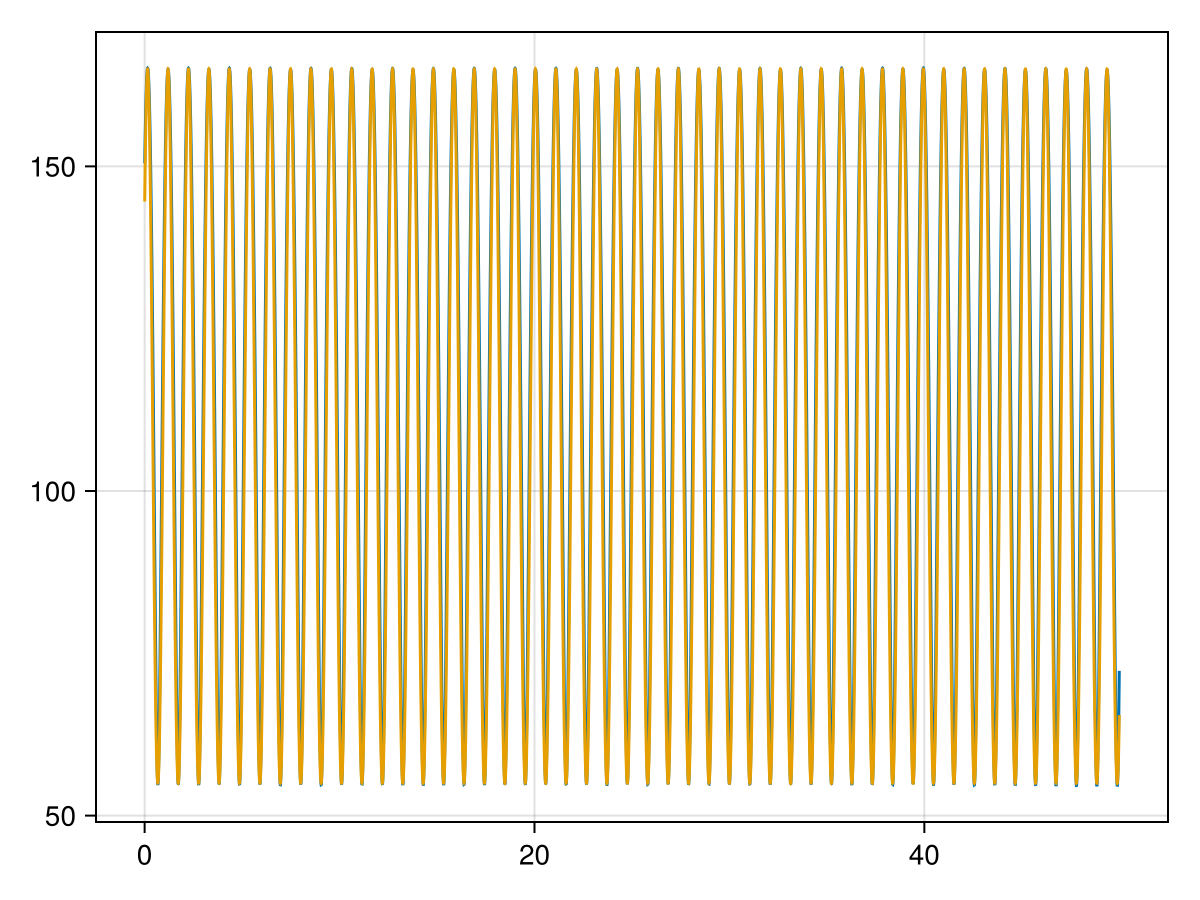

In [158]:
f = Figure()
ax = Axis(f[1,1])
dt = 5e-3
t = (1:10000) * dt
lines!(ax, t, abs.(w[1:10000]))
lines!(ax, t, 110 .+ 55*sin.(2 * ω₀ * t .+ 0.65))
f

In [70]:
1/(last_file["snapshots/t/25101"] - last_file["snapshots/t/25100"])

200.0000000001819

In [22]:
last_file = jldopen(@sprintf("../data/thomasyamada_data/long-run2/ty.jld2.%08d.jld2", 251))

JLDFile /scratch/nad9961/thomasyamada_simulation/46165975/ty.jld2.00000251.jld2 (read-only)
 └─📂 snapshots
    ├─📂 t
    │  ├─🔢 25100
    │  ├─🔢 25101
    │  ├─🔢 25102
    │  ├─🔢 25103
    │  ├─🔢 25104
    │  ├─🔢 25105
    │  └─ ⋯ (29 more entries)
    └─📂 sol (35 entries)

In [23]:
length(keys(last_file["snapshots/t"]))

35

In [82]:
my_freq = 3.5
f(t) = 2.5 * cos(my_freq * t + 0.3)

f (generic function with 1 method)

In [83]:
using CairoMakie
using AbstractFFTs

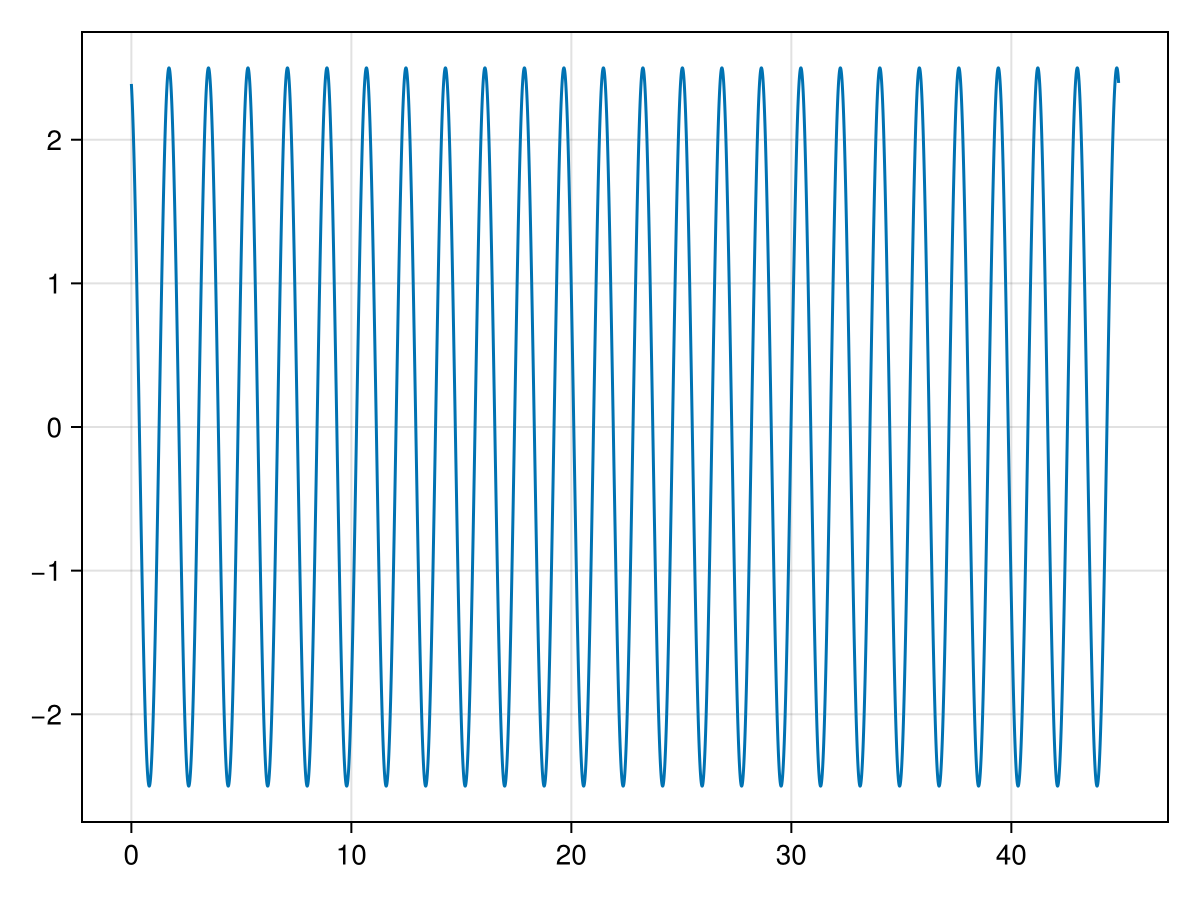

In [84]:
sampling_rate = 1e-2/my_freq
t = 0:sampling_rate:(25/my_freq*2*π)

samples = f.(t)
lines(t, samples)

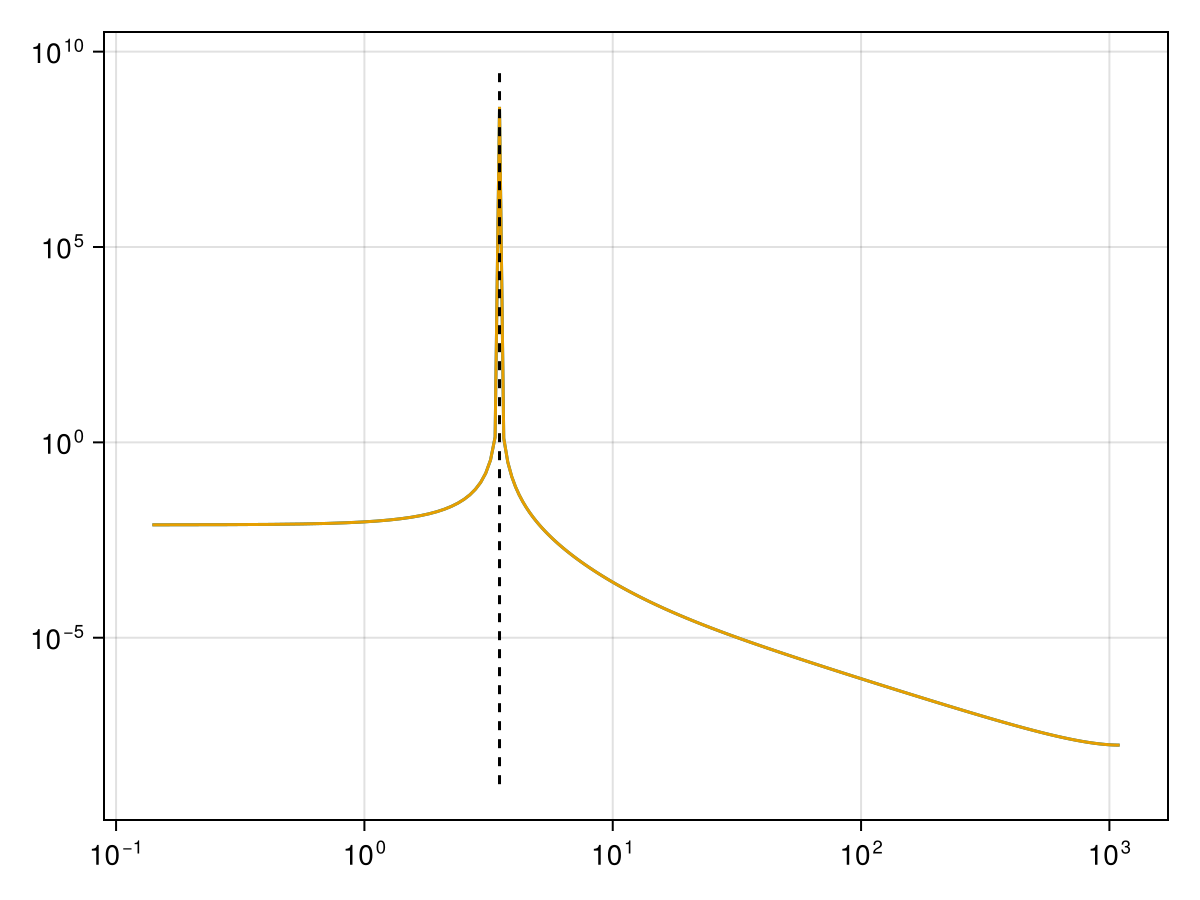

In [101]:
ns = length(samples)
half_ns = floor(Int, ns/2)
window = hann(ns)

ωs = fftshift(fftfreq(ns, 1/sampling_rate)) * 2*π
power = abs2.(fftshift(fft(samples)))

fig = Figure()
ax = Axis(fig[1,1], xscale=log10, yscale=log10)
#lines!(ax, ωs, power)
lines!(ax, -ωs[1:half_ns], power[1:half_ns])
lines!(ax, ωs[half_ns+2:end], power[half_ns+2:end])
lines!(ax, [my_freq, my_freq], [minimum(power)/10, maximum(power)*10]; linestyle=:dash, color="black")
fig

In [40]:
ωs[floor(Int, ns/2)]

-49.9980000799968:0.003999840006399744:49.9980000799968